In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
import glob
from copy import deepcopy

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import equinox as eqx 

In [3]:
from rhmag.utils.final_data_evaluation import (
    FINAL_MATERIALS, TestSet, ResultSet, predict_test_scenarios, validate_result_set, visualize_result_set
)
from rhmag.utils.model_evaluation import reconstruct_model_from_file, get_exp_ids

INFO:2026-01-27 17:56:41,159:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2026-01-27 17:56:41 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


---

## Checkout available models:

In [4]:
FINAL_MATERIALS

['A', 'B', 'C', 'D', 'E']

In [5]:
for material_name in FINAL_MATERIALS:
    print(material_name)
    print(get_exp_ids(material_name=material_name, model_type=None))
    print()

A
['A_JA_demonstration_c48c1f4f_seed2', 'A_JA_demonstration_c48c1f4f_seed1', 'A_JA_demonstration_c48c1f4f_seed3', 'A_GRU8_reduced-features-f32_2a1473b6_seed12', 'A_GRU4_demonstration_dad948ee_seed1', 'A_GRU8_final-reduced-features-f32_0d2b6cb5_seed12', 'A_GRU4_demonstration_dad948ee_seed2', 'A_GRU4_demonstration_dad948ee_seed3']

B
['B_GRU8_reduced-features-f32_c785b2c3_seed12', 'B_DummyModel_c48e643b_seed155', 'B_DummyModel_4d03c358_seed155', 'B_GRU8_final-reduced-features-f32_6437bf39_seed12']

C
['C_GRU8_final-reduced-features-f32_5fe02cfa_seed12', 'C_GRU8_reduced-features-f32_348e220c_seed12']

D
['D_GRU8_reduced-features-f32_b6ac55b5_seed12', 'D_GRU8_final-reduced-features-f32_3d0f8de4_seed12']

E
['E_GRU8_final-reduced-features-f32_8f8a200e_seed12', 'E_GRU8_reduced-features-f32_e88a2583_seed12']



## Choose and load models:

In [6]:
# map_letter_to_material = {
#     "A": "3C92",
#     "B": "3C95",
#     "C": "FEC007",
#     "D": "FEC014",
#     "E": "T37",
# }

In [7]:
# GRU8 all features
# exp_ids = {
#     "A": 'A_GRU8_final-f32_70d342ee_seed105',
#     "B": 'B_GRU8_final-f32_c314f005_seed6',
#     "C": 'C_GRU8_final-f32_e8fe195e_seed12',
#     "D": 'D_GRU8_final-f32_09d3ce02_seed12',
#     "E": 'E_GRU8_final-f32_cfbcb9e6_seed53',
# }

exp_ids = {
    "A": 'A_GRU8_final-reduced-features-f32_0d2b6cb5_seed12',
    "B": 'B_GRU8_final-reduced-features-f32_6437bf39_seed12',
    "C": 'C_GRU8_final-reduced-features-f32_5fe02cfa_seed12',
    "D": 'D_GRU8_final-reduced-features-f32_3d0f8de4_seed12',
    "E": 'E_GRU8_final-reduced-features-f32_8f8a200e_seed12',
}

# GRU8 reduced_features:
# exp_ids = {
#     map_letter_to_material["A"]: 'A_GRU8_final-reduced-features-f32_0d2b6cb5_seed12',
#     map_letter_to_material["B"]: 'B_GRU8_final-reduced-features-f32_6437bf39_seed12',
#     map_letter_to_material["C"]: 'C_GRU8_final-reduced-features-f32_5fe02cfa_seed12',
#     map_letter_to_material["D"]: 'D_GRU8_final-reduced-features-f32_3d0f8de4_seed12',
#     map_letter_to_material["E"]: 'E_GRU8_final-reduced-features-f32_8f8a200e_seed12',
# }

models = {material_name: reconstruct_model_from_file(exp_id) for material_name, exp_id in exp_ids.items()}
# models

Found model file at '/home/hvater/projects/RHINO-MAG/data/models/A_GRU8_final-reduced-features-f32_0d2b6cb5_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/B_GRU8_final-reduced-features-f32_6437bf39_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/C_GRU8_final-reduced-features-f32_5fe02cfa_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/D_GRU8_final-reduced-features-f32_3d0f8de4_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/E_GRU8_final-reduced-features-f32_8f8a200e_seed12.eqx'. Loading model..


## Run models on test data:

In [8]:
# test_data = {map_letter_to_material[material_name]: TestSet.from_material_name(map_letter_to_material[material_name]) for material_name in FINAL_MATERIALS}
test_data = {material_name: TestSet.from_material_name(material_name) for material_name in FINAL_MATERIALS}

Loading data for E: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.38it/s]


In [9]:
test_data

{'A': TestSet(
   material_name='A',
   H=f64[1260,1000],
   B=f64[1260,1000],
   T=i64[1260,1],
   H_gt=f64[1260,1000],
   core_loss_gt=f64[1260,1]
 ),
 'B': TestSet(
   material_name='B',
   H=f64[945,1000],
   B=f64[945,1000],
   T=i64[945,1],
   H_gt=f64[945,1000],
   core_loss_gt=f64[945,1]
 ),
 'C': TestSet(
   material_name='C',
   H=f64[1116,1000],
   B=f64[1116,1000],
   T=i64[1116,1],
   H_gt=f64[1116,1000],
   core_loss_gt=f64[1116,1]
 ),
 'D': TestSet(
   material_name='D',
   H=f64[1242,1000],
   B=f64[1242,1000],
   T=i64[1242,1],
   H_gt=f64[1242,1000],
   core_loss_gt=f64[1242,1]
 ),
 'E': TestSet(
   material_name='E',
   H=f64[1080,1000],
   B=f64[1080,1000],
   T=i64[1080,1],
   H_gt=f64[1080,1000],
   core_loss_gt=f64[1080,1]
 )}

In [10]:
result_sets = predict_test_scenarios(
    models,
    test_data,
    exp_ids,
)

Evaluate test data for material:  A
The model has 325 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 900 steps and 100 unknown elements.
Done with material: A 

Evaluate test data for material:  B
The model has 325 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 900 steps and 100 unknown elements.
Done with material: B 

Evaluate test data for material:  C
The model has 325 parameters.
Running scenario with a warmup of 1 steps and 999 unknown elements.
Done with material: C 

Evaluate test data for material:  D
The model has 325 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 90

## Inspect results:

In [11]:
for material_name in FINAL_MATERIALS:
    result_set = result_sets[material_name]
    test_set = test_data[material_name]
    assert result_set.material_name == material_name
    validate_result_set(result_set, test_set)

Sanity checking results for material: A
Results for 'A' seem consistent with the test data.
Sanity checking results for material: B
Results for 'B' seem consistent with the test data.
Sanity checking results for material: C
Results for 'C' seem consistent with the test data.
Sanity checking results for material: D
Results for 'D' seem consistent with the test data.
Sanity checking results for material: E
Results for 'E' seem consistent with the test data.


Visualization for material: A


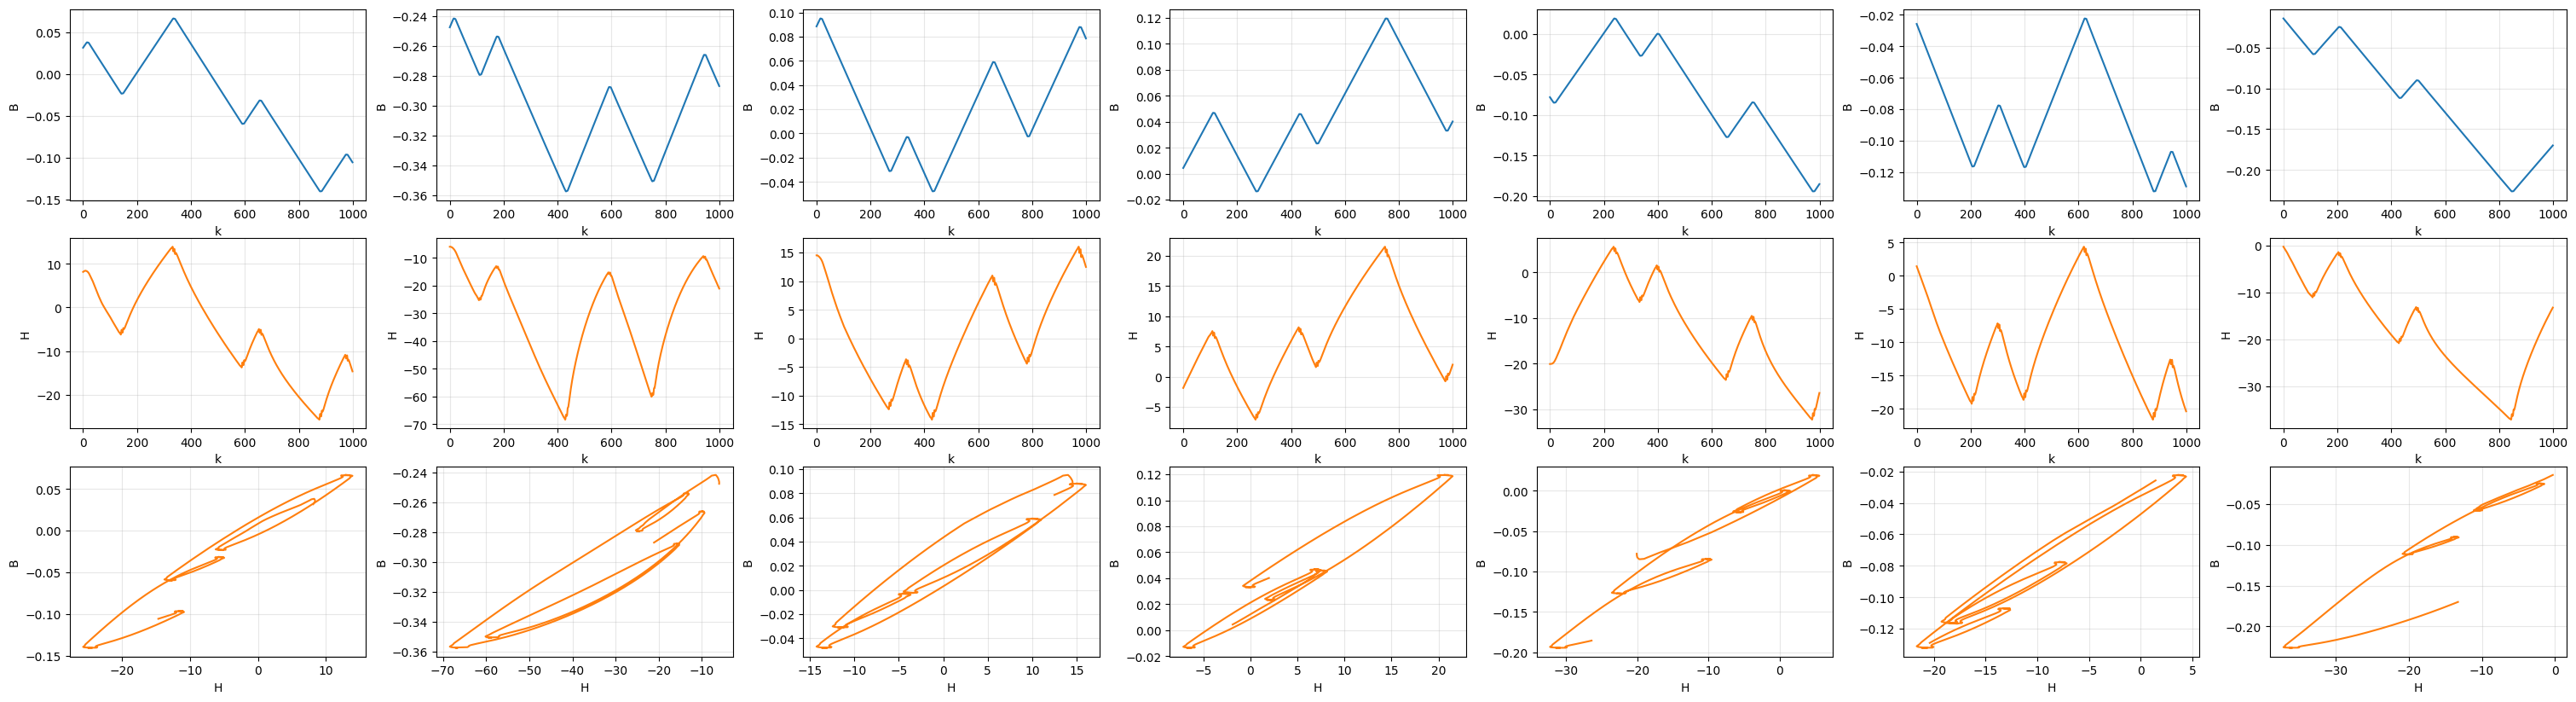

Visualization for material: B


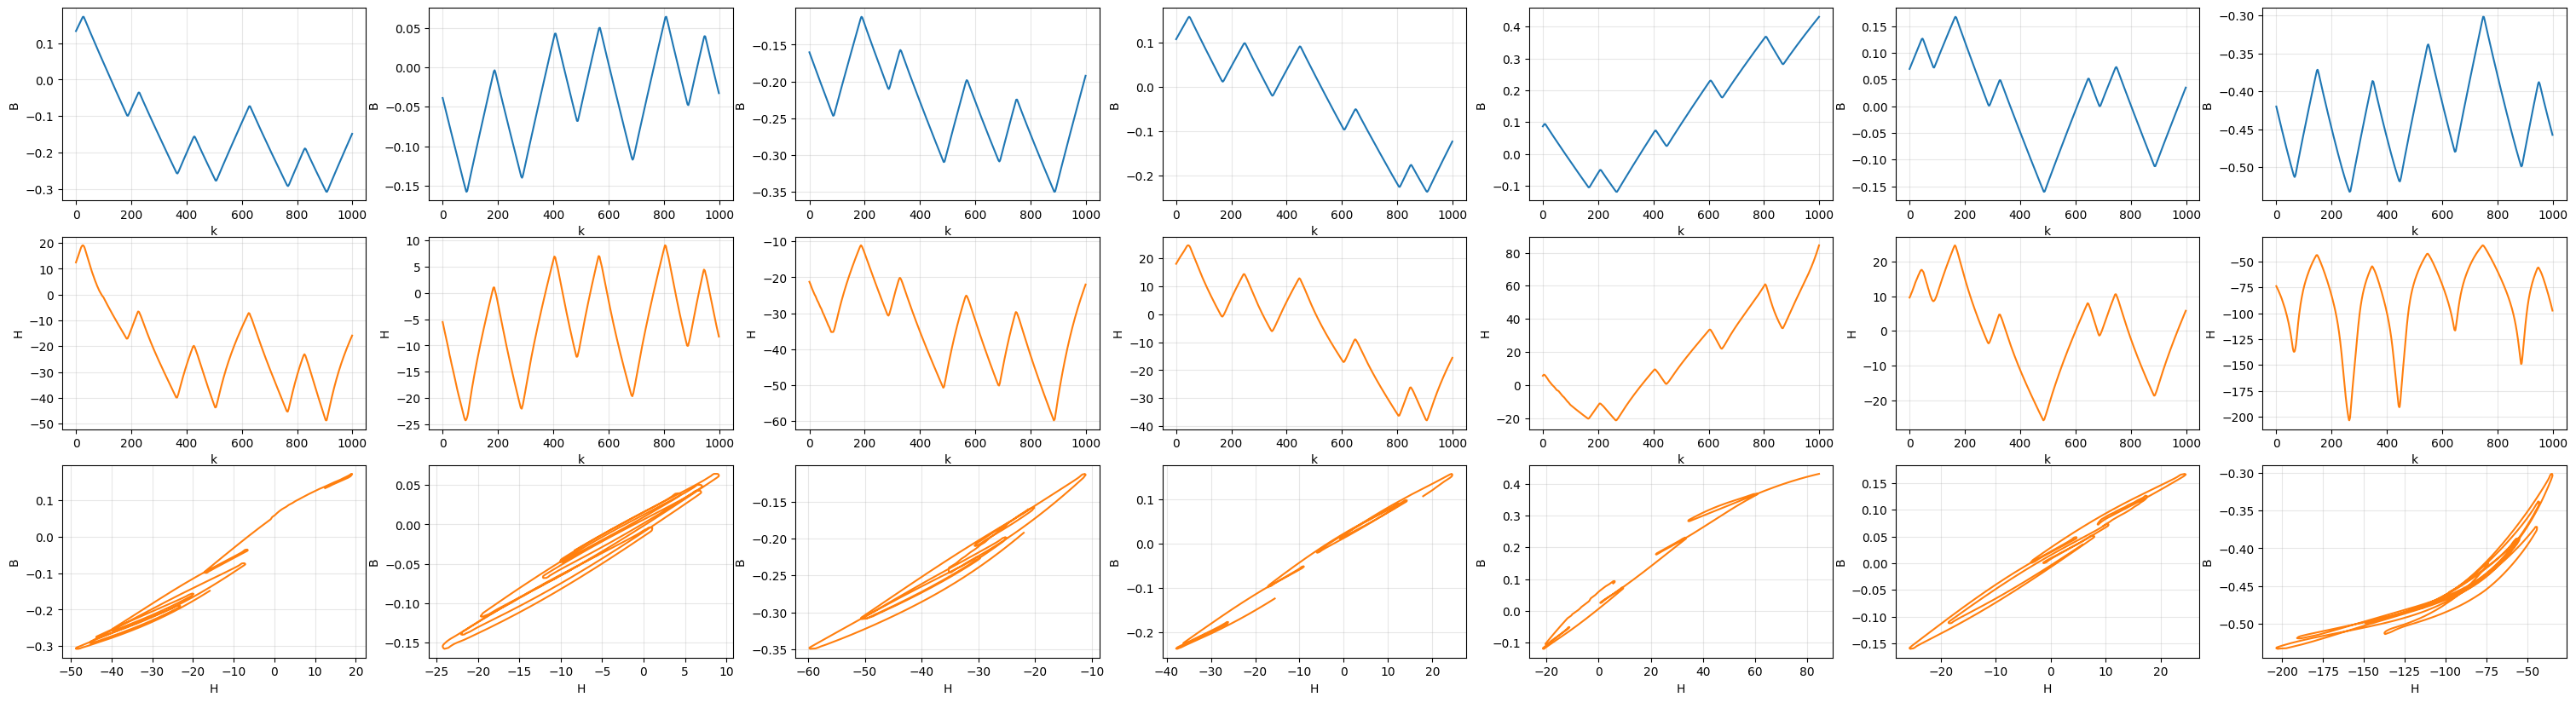

Visualization for material: C


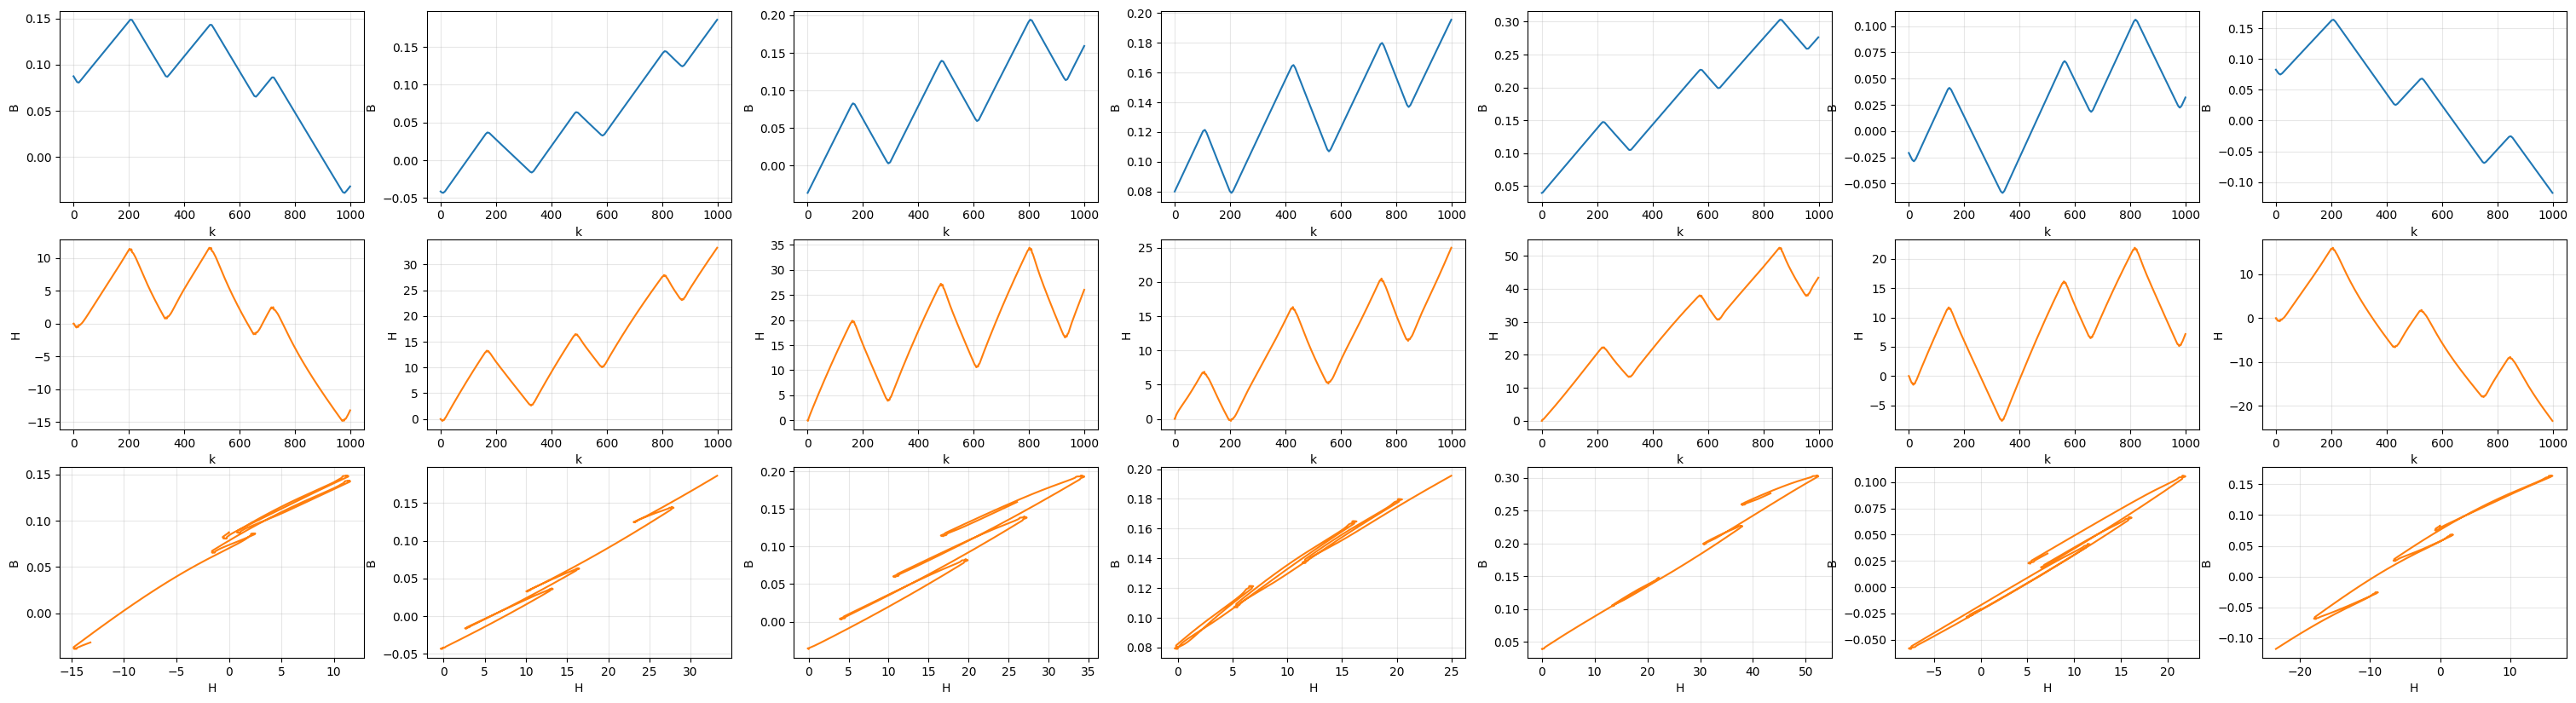

Visualization for material: D


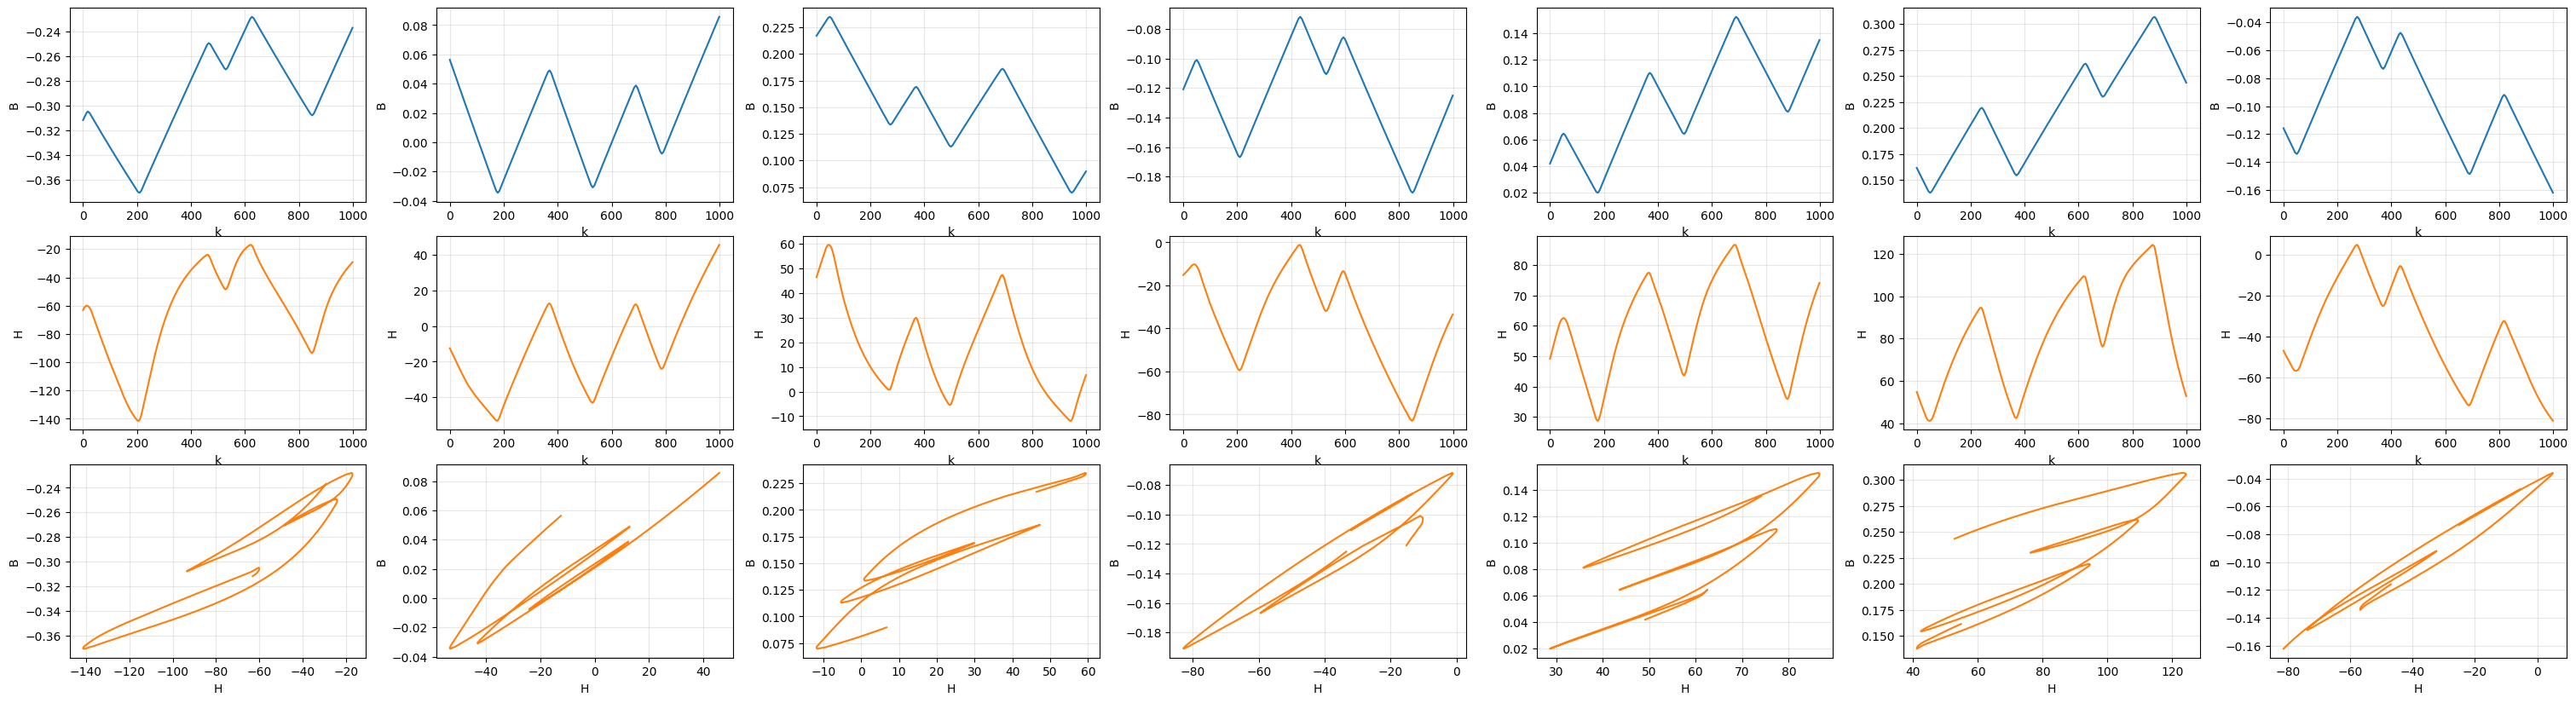

Visualization for material: E


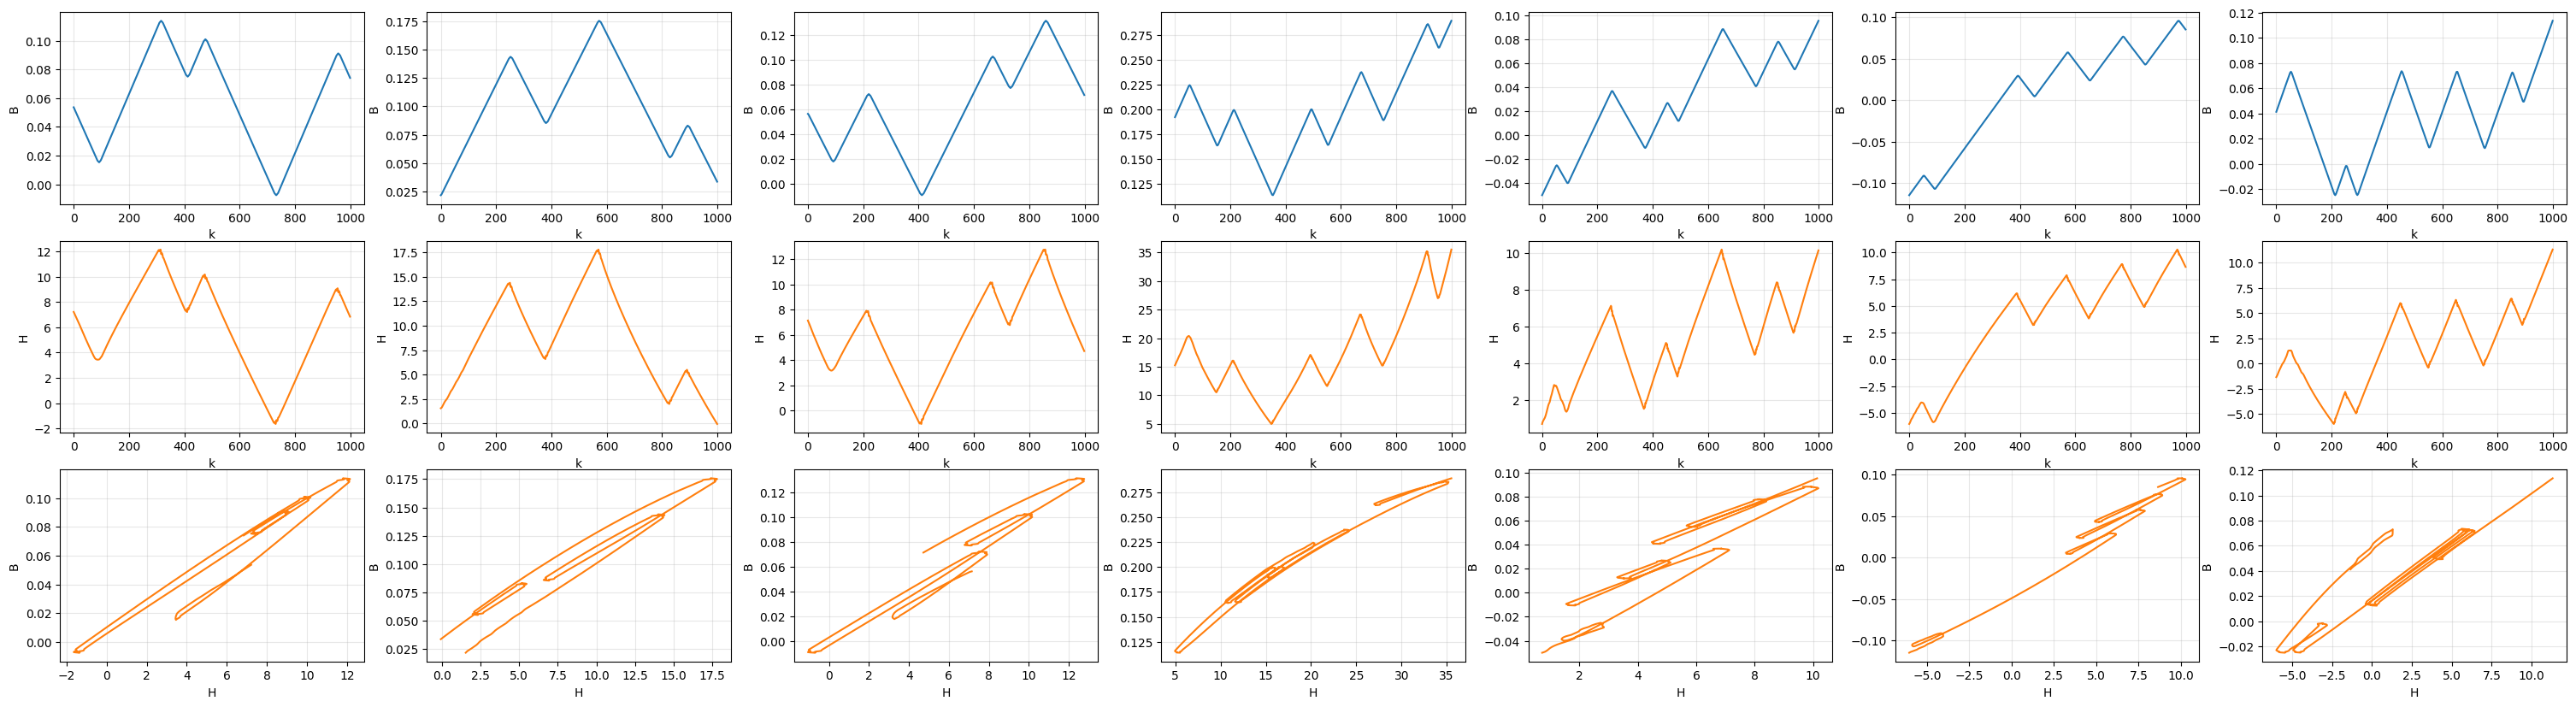

In [12]:
# Visualize result_sets
for material_name, result_set in result_sets.items():
    print("Visualization for material:", material_name)
    visualize_result_set(result_set)
    plt.show()

## Store results:

In [13]:
#from rhmag.data_management import DATA_ROOT

In [14]:
# # store to csv
# save_path = DATA_ROOT / "final_results"

# for material_name, result_set in result_sets.items():
#     with open(save_path / f"{result_set.exp_id}_final_test_prediction.csv", "w") as f:
#         np.savetxt(f, result_set.H, delimiter=",")
#         f.close()

## Compare to GT - Verifying posted results:

In [15]:
from rhmag.utils.pretest_evaluation import create_multilevel_df
from rhmag.utils.final_data_evaluation import evaluate_test_scenarios

In [16]:
metrics_per_material = {}

for material_name in FINAL_MATERIALS:
    model = models[material_name]
    test_set = test_data[material_name]

    metrics_per_sequence = evaluate_test_scenarios(model, test_set)
    metrics_per_material[material_name] = metrics_per_sequence


Evaluate test data for material:  A
The model has 325 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 900 steps and 100 unknown elements.
	MSE :    2.51 (A/m)²
	WCE :   15.78 A/m
	MSE :    2.27 (A/m)²
	WCE :   18.62 A/m
	MSE :    1.12 (A/m)²
	WCE :   15.98 A/m
Evaluate test data for material:  B
The model has 325 parameters.
Running scenario with a warmup of 100 steps and 900 unknown elements.
Running scenario with a warmup of 500 steps and 500 unknown elements.
Running scenario with a warmup of 900 steps and 100 unknown elements.
	MSE :    2.15 (A/m)²
	WCE :   39.63 A/m
	MSE :    1.19 (A/m)²
	WCE :   37.00 A/m
	MSE :    0.87 (A/m)²
	WCE :   34.00 A/m
Evaluate test data for material:  C
The model has 325 parameters.
Running scenario with a warmup of 1 steps and 999 unknown elements.
	MSE :    1.06 (A/m)²
	WCE :    9.31 A/m
Evaluate test data for mate

In [17]:
metrics_per_material

{'A': {'10%known_90%unknown': {'sre_avg': 0.1178,
   'sre_95th': 0.2207,
   'nere_avg': 0.0111,
   'nere_95th': 0.0347},
  '50%known_50%unknown': {'sre_avg': 0.1106,
   'sre_95th': 0.2078,
   'nere_avg': 0.0068000000000000005,
   'nere_95th': 0.0214},
  '90%known_10%unknown': {'sre_avg': 0.1009,
   'sre_95th': 0.2613,
   'nere_avg': 0.0016,
   'nere_95th': 0.0048}},
 'B': {'10%known_90%unknown': {'sre_avg': 0.0729,
   'sre_95th': 0.1506,
   'nere_avg': 0.0224,
   'nere_95th': 0.0685},
  '50%known_50%unknown': {'sre_avg': 0.06960000000000001,
   'sre_95th': 0.1838,
   'nere_avg': 0.0117,
   'nere_95th': 0.0407},
  '90%known_10%unknown': {'sre_avg': 0.052700000000000004,
   'sre_95th': 0.1893,
   'nere_avg': 0.0027,
   'nere_95th': 0.0095}},
 'C': {'0%known_99%unknown': {'sre_avg': 0.094,
   'sre_95th': 0.2763,
   'nere_avg': 0.0182,
   'nere_95th': 0.0491}},
 'D': {'10%known_90%unknown': {'sre_avg': 0.076,
   'sre_95th': 0.204,
   'nere_avg': 0.0173,
   'nere_95th': 0.0662},
  '50%known

posted results:

In [18]:
import json
from rhmag.utils.final_data_evaluation import SIEGEN_PB_HOST_PROVIDED_RESULTS

In [19]:
create_multilevel_df(metrics_per_material)

10%known_90%unknown                             50%known_50%unknown  \
              sre_avg sre_95th nere_avg nere_95th             sre_avg   
A              0.1178   0.2207   0.0111    0.0347              0.1106   
B              0.0729   0.1506   0.0224    0.0685              0.0696   
C                 NaN      NaN      NaN       NaN                 NaN   
D              0.0760   0.2040   0.0173    0.0662              0.0648   
E              0.0773   0.1792   0.0095    0.0278              0.0757   

                              90%known_10%unknown                              \
  sre_95th nere_avg nere_95th             sre_avg sre_95th nere_avg nere_95th   
A   0.2078   0.0068    0.0214              0.1009   0.2613   0.0016    0.0048   
B   0.1838   0.0117    0.0407              0.0527   0.1893   0.0027    0.0095   
C      NaN      NaN       NaN                 NaN      NaN      NaN       NaN   
D   0.1682   0.0124    0.0474              0.0405   0.1139   0.0029    0.0117   
E   0.1936   0.0059    0.0195              0.0618   0.1786   0.0014    0.0046   

  0%known_99%unknown                              
             sre_avg sre_95th nere_avg nere_95th  
A                NaN      NaN      NaN       NaN  
B                NaN      NaN      NaN       NaN  
C              0.094   0.2763   0.0182    0.0491  
D                NaN      NaN      NaN       NaN  
E                NaN      NaN      NaN       NaN

In [20]:
create_multilevel_df(SIEGEN_PB_HOST_PROVIDED_RESULTS)

10%known_90%unknown                              50%known_50%unknown  \
              sre_avg sre_95th  nere_avg nere_95th             sre_avg   
A             0.11830   0.2162  0.011150   0.03542             0.11100   
B             0.07224   0.1517  0.023120   0.06938             0.06861   
C                 NaN      NaN       NaN       NaN                 NaN   
D             0.07594   0.2051  0.017960   0.06917             0.06425   
E             0.07591   0.1756  0.009387   0.02661             0.07429   

                               90%known_10%unknown                     \
  sre_95th  nere_avg nere_95th             sre_avg sre_95th  nere_avg   
A   0.2178  0.006782   0.02195             0.10090   0.2642  0.001620   
B   0.1771  0.011990   0.03858             0.05275   0.1910  0.002668   
C      NaN       NaN       NaN                 NaN      NaN       NaN   
D   0.1676  0.012510   0.05295             0.04043   0.1133  0.002865   
E   0.1983  0.005910   0.01955             0.06155   0.1771  0.001415   

            1%known_99%unknown                              
  nere_95th            sre_avg sre_95th nere_avg nere_95th  
A  0.004900                NaN      NaN      NaN       NaN  
B  0.009933                NaN      NaN      NaN       NaN  
C       NaN            0.09273     0.27  0.01808   0.04849  
D  0.012210                NaN      NaN      NaN       NaN  
E  0.004651                NaN      NaN      NaN       NaN